## MARBL diagnostics for vertical and horizontal nutrient distribution for ocean history files

## This notebook compares 3 tuning runs

In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import os
from glob import glob
from collections import OrderedDict
import xarray as xr
import numpy as np
import esmlab
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import seawater as sw
from seawater.library import T90conv
from scipy import stats

### Define the years over which to average, the case and experiment name

In [2]:
start_yr = 3 #start at year 3 and get 2 years over which to average
num_years = 1
endyr = start_yr + num_years 
casename1 = 'g.e22a06.G1850ECOIAF.T62_g37.4p4z.'
user = 'kristenk'

### What happens when I vary zoo4's z_mort2_0_per_day?

In [3]:
varname='z4_mort2'

In [4]:
#define test cases
casenums=[varname+'_1', varname+'_2', varname+'_3']
test_vals=[0.01,0.008,0.003]
default

In [9]:
casenums=['001','002','003']

### Define variables that would be interesting

In [3]:
variables = ['sp_Fe_lim_surf','sp_P_lim_surf','sp_N_lim_surf',
             'diat_Fe_lim_surf', 'diat_P_lim_surf','diat_N_lim_surf',
             'diat_SiO3_lim_surf','diaz_P_lim_surf',
             'diaz_Fe_lim_surf','photoC_TOT_zint','photoC_sp_zint',
             'photoC_diat_zint','photoC_diaz_zint','photoC_cocco_zint',
             'cocco_Fe_lim_surf','cocco_C_lim_surf','cocco_N_lim_surf',
             'cocco_P_lim_surf','CaCO3_PROD_zint','SiO2_PROD','POC_FLUX_100m',
             'coccoCaCO3','diatC', 'coccoC','spC','diazC','ALK','SALT',
             'PO4','Fe','NO3','SiO3','ALK',
             'spChl','diatChl','diazChl','coccoChl',
            'zoo1C','zoo2C','zoo3C','zoo4C','x_graze_zoo1_zint','x_graze_zoo2_zint',
            'x_graze_zoo3_zint','x_graze_zoo4_zint'] 
coords = {'x':'TLONG','y':'TLAT'}

keepthese=['z_t','z_t_150m','time_bound','TAREA','REGION_MASK'] + variables
keep_vars = keepthese +list(coords.values())+['dz','KMT']

### open each dataset and put them in a dictionary organized by casenum

In [4]:
ds_dict = {}
for casenum in casenums:
    case=casename1 + '.' + exp + '.' + casenum
    print(case)
    files = []
    for year in range(start_yr,endyr):
        
        yr4 = "{:04d}".format(year)
        print('doing simulation year', year, '!')
        for month in range(1, 13):

            mo2 = "{:02d}".format(month)
            files.extend(sorted(glob(f'/glade/scratch/{user}/archive/{case}/ocn/hist/{case}.pop.h.{yr4}-{mo2}.nc')))
            
            ds = xr.open_mfdataset(files,decode_times=False,decode_coords=False, concat_dim='time')
            ds = ds.drop([v for v in ds.variables if v not in keep_vars])
            ds = ds.mean(dim='time')
            
            ds_dict[casenum] = ds

g.e22a06.G1850ECOIAF.T62_g37.4p4z.test1.001
doing simulation year 3 !
doing simulation year 4 !
g.e22a06.G1850ECOIAF.T62_g37.4p4z.test1.002
doing simulation year 3 !
doing simulation year 4 !
g.e22a06.G1850ECOIAF.T62_g37.4p4z.test1.003
doing simulation year 3 !
doing simulation year 4 !


In [5]:
file = '/glade/work/kristenk/WOA_data/regrid_POP/WOA2018_x3POPgrid.nc' 
ds_woa = xr.load_dataset(file, decode_times=False, decode_coords=False)

In [6]:
lons=ds_woa.TLONG
lats=ds_woa.TLAT
area=ds_woa.TAREA
depths=ds_woa.z_t * 0.01

### Evaluation of global nutrient distributions

In [10]:
rmse_dict={}

for casenum in casenums:
    
    ds_dict[casenum]['z_t']=ds_woa.z_t

    rmse_global = xr.Dataset({v: ds_dict[casenum][v] for v in ['z_t']})
    #help(esmlab.statistics)
    rmse_global['NO3']=esmlab.statistics.weighted_rmsd(ds_dict[casenum].NO3, ds_woa.NO3, dim=['nlat', 'nlon'], weights=area)
    rmse_global['PO4']=esmlab.statistics.weighted_rmsd(ds_dict[casenum].PO4, ds_woa.PO4, dim=['nlat', 'nlon'], weights=area)
    rmse_global['SiO3']=esmlab.statistics.weighted_rmsd(ds_dict[casenum].SiO3, ds_woa.SiO3, dim=['nlat', 'nlon'], weights=area)
    
    rmse_dict[casenum]=rmse_global

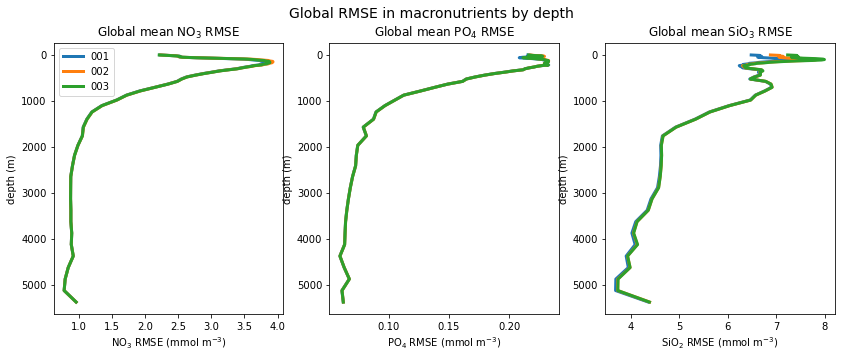

In [13]:
fig = plt.figure(figsize=(14,5))

plt.suptitle('Global RMSE in macronutrients by depth', fontsize=14)
#################
ax = fig.add_subplot(1,3,1)
ax.set_title('Global mean NO$_3$ RMSE')
for casenum in casenums:
    ax.plot(rmse_dict[casenum]['NO3'].values, depths, label=casenum, linewidth=3)
ax.legend()
ax.set(ylabel='depth (m)',xlabel='NO$_3$ RMSE (mmol m$^{-3}$)')
plt.gca().invert_yaxis()
#################
ax = fig.add_subplot(1,3,2)
ax.set_title('Global mean PO$_4$ RMSE')
for casenum in casenums:
    ax.plot(rmse_dict[casenum]['PO4'].values, depths, label=casenum, linewidth=3)
ax.set(ylabel='depth (m)',xlabel='PO$_4$ RMSE (mmol m$^{-3}$)')
plt.gca().invert_yaxis()
#################
ax = fig.add_subplot(1,3,3)
ax.set_title('Global mean SiO$_3$ RMSE')
for casenum in casenums:
    ax.plot(rmse_dict[casenum]['SiO3'].values, depths, label=casenum, linewidth=3)
ax.set(ylabel='depth (m)',xlabel='SiO$_2$ RMSE (mmol m$^{-3}$)')
plt.gca().invert_yaxis()
#################

### Nutrient bias maps

In [12]:
diff_dict={}

for casenum in casenums:
    
    ds_diff=xr.Dataset()
    
    #just do surface diffs
    ds_diff['PO4']=ds_dict[casenum].PO4.isel(z_t=0) - ds_woa.PO4.isel(z_t=0)
    ds_diff['SiO3']=ds_dict[casenum].SiO3.isel(z_t=0) - ds_woa.SiO3.isel(z_t=0)
    ds_diff['NO3']=ds_dict[casenum].NO3.isel(z_t=0) - ds_woa.NO3.isel(z_t=0)
    
    diff_dict[casenum]=ds_diff

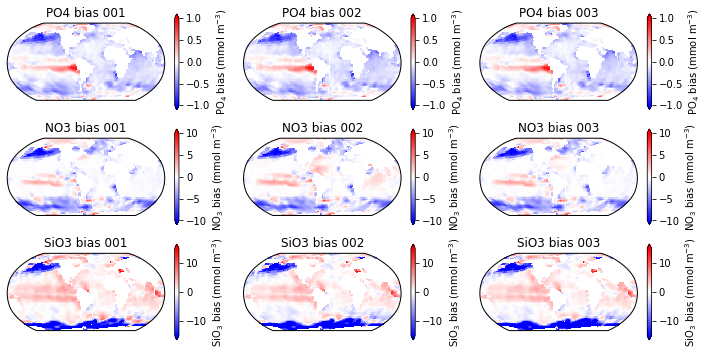

In [14]:
fig = plt.figure(figsize=(12,6))
column=0

for casenum in casenums:
    
    column=column+1
    #print(plot_num)
    plot_num=column+0
    ax = fig.add_subplot(3,3,plot_num, projection=ccrs.Robinson(central_longitude=305.0))
    ax.set_title('PO4 bias '+ casenum, fontsize=12)
    pc=ax.pcolormesh(lons, lats, diff_dict[casenum]['PO4'], cmap='bwr',vmin=-1, vmax=1,transform=ccrs.PlateCarree())
    cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='PO$_4$ bias (mmol m$^{-3}$)')

    
    plot_num=plot_num+3
    ax = fig.add_subplot(3,3,plot_num, projection=ccrs.Robinson(central_longitude=305.0))
    ax.set_title('NO3 bias '+ casenum, fontsize=12)
    pc=ax.pcolormesh(lons, lats, diff_dict[casenum]['NO3'], cmap='bwr',vmin=-10,vmax=10 ,transform=ccrs.PlateCarree())
    cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='NO$_3$ bias (mmol m$^{-3}$)')

    plot_num=plot_num+3
    ax = fig.add_subplot(3,3,plot_num, projection=ccrs.Robinson(central_longitude=305.0))
    ax.set_title('SiO3 bias '+ casenum, fontsize=12)
    pc=ax.pcolormesh(lons, lats, diff_dict[casenum]['SiO3'], cmap='bwr',vmin=-15,vmax=15,transform=ccrs.PlateCarree())
    cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='SiO$_3$ bias (mmol m$^{-3}$)')


### Phytoplankton nutrient limitation at surface

In [15]:
#most limiting nutrient - concatenate the limitation terms so that nutrient limitation terms are each along the 'nutrient' dimension
# 0 = PO4
# 1 = Fe
# 2 = NO3 (only for sp and diat)
# 3 = Si (only for diat)
# 3 = C (only for cocco)
mask = np.isnan(ds_dict[casenum].sp_N_lim_surf.squeeze())

lim_dict={}

for casenum in casenums:
    
    most_lim_ds=xr.Dataset()
    
    limarray_sp=xr.concat((ds_dict[casenum].sp_P_lim_surf, ds_dict[casenum].sp_Fe_lim_surf,ds_dict[casenum].sp_N_lim_surf),dim='nutrient')
    limarray_diat=xr.concat((ds_dict[casenum].diat_P_lim_surf, ds_dict[casenum].diat_Fe_lim_surf, ds_dict[casenum].diat_N_lim_surf, ds_dict[casenum].diat_SiO3_lim_surf),dim='nutrient')
    limarray_diaz=xr.concat((ds_dict[casenum].diaz_P_lim_surf, ds_dict[casenum].diaz_Fe_lim_surf),dim='nutrient')
    limarray_cocco=xr.concat((ds_dict[casenum].cocco_P_lim_surf, ds_dict[casenum].cocco_Fe_lim_surf, ds_dict[casenum].cocco_N_lim_surf, ds_dict[casenum].cocco_C_lim_surf),dim='nutrient')
    
    most_lim_ds['sp']=limarray_sp.argmin(dim='nutrient', skipna=False).squeeze()
    most_lim_ds['diat']=limarray_diat.argmin(dim='nutrient', skipna=False).squeeze()
    most_lim_ds['diaz']=limarray_diaz.argmin(dim='nutrient', skipna=False).squeeze()
    most_lim_ds['cocco']=limarray_cocco.argmin(dim='nutrient', skipna=False).squeeze()

    lim_dict[casenum]=most_lim_ds

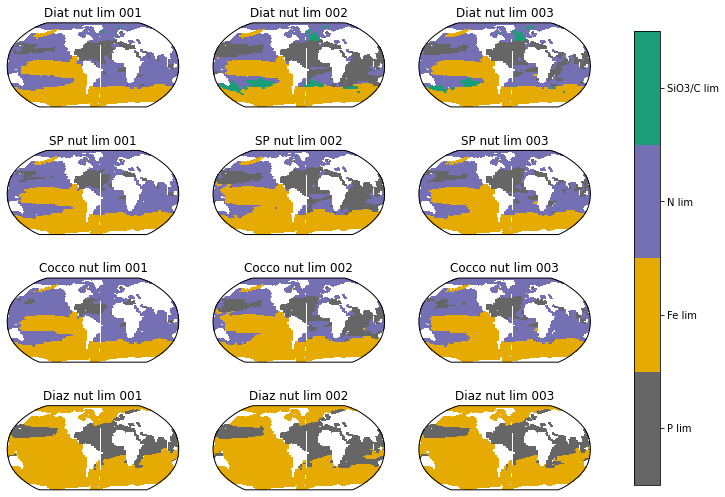

In [16]:
fig = plt.figure(figsize=(12,9))
column=0

for casenum in casenums:
    
    column=column+1
    #print(plot_num)
    plot_num=column+0
    ax = fig.add_subplot(4,3,plot_num, projection=ccrs.Robinson(central_longitude=305.0))
    ax.set_title('Diat nut lim '+ casenum, fontsize=12)
    pc=ax.pcolormesh(lons, lats, lim_dict[casenum]['diat'].where(~mask), cmap=plt.cm.get_cmap('Dark2_r',4),vmin=-0.5,vmax=3.5,transform=ccrs.PlateCarree())
    colorbar_specs = {'ticks' : np.arange(0,4,1)}
    
    plot_num=plot_num+3
    ax = fig.add_subplot(4,3,plot_num, projection=ccrs.Robinson(central_longitude=305.0))
    ax.set_title('SP nut lim '+ casenum, fontsize=12)
    pc=ax.pcolormesh(lons, lats, lim_dict[casenum]['sp'].where(~mask), cmap=plt.cm.get_cmap('Dark2_r',4),vmin=-0.5,vmax=3.5,transform=ccrs.PlateCarree())
    colorbar_specs = {'ticks' : np.arange(0,4,1)}
    
    plot_num=plot_num+3
    ax = fig.add_subplot(4,3,plot_num, projection=ccrs.Robinson(central_longitude=305.0))
    ax.set_title('Cocco nut lim '+ casenum, fontsize=12)
    pc=ax.pcolormesh(lons, lats, lim_dict[casenum]['cocco'].where(~mask), cmap=plt.cm.get_cmap('Dark2_r',4),vmin=-0.5,vmax=3.5,transform=ccrs.PlateCarree())
    colorbar_specs = {'ticks' : np.arange(0,4,1)}
    
    plot_num=plot_num+3
    ax = fig.add_subplot(4,3,plot_num, projection=ccrs.Robinson(central_longitude=305.0))
    ax.set_title('Diaz nut lim '+ casenum, fontsize=12)
    pc=ax.pcolormesh(lons, lats, lim_dict[casenum]['diaz'].where(~mask), cmap=plt.cm.get_cmap('Dark2_r',4),vmin=-0.5,vmax=3.5,transform=ccrs.PlateCarree())
    colorbar_specs = {'ticks' : np.arange(0,4,1)}

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.03, 0.7])
cbar = fig.colorbar(pc, cax=cbar_ax,**colorbar_specs)
cbar.ax.set_yticklabels(['P lim', 'Fe lim', 'N lim','SiO3/C lim']);

### Look at phyto carbon pools

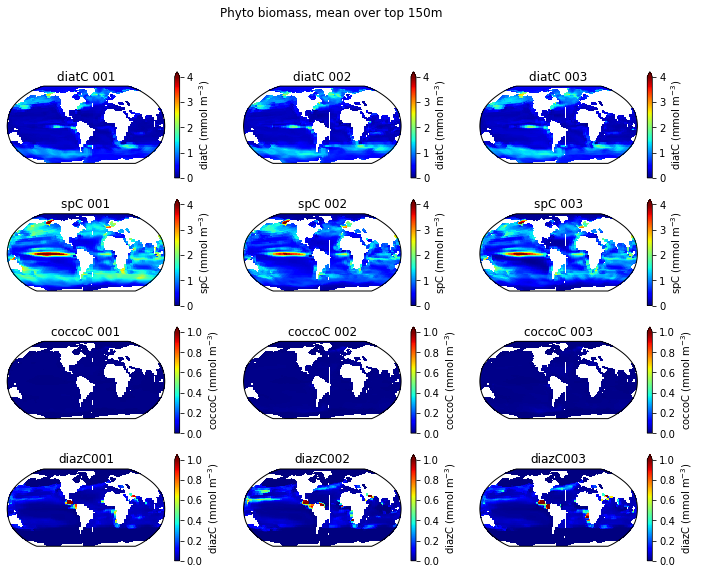

In [17]:
fig = plt.figure(figsize=(12,9))
column=0
plt.suptitle('Phyto biomass, mean over top 150m')
for casenum in casenums:
    
    column=column+1
    #print(plot_num)
    plot_num=column+0
    ax = fig.add_subplot(4,3,plot_num, projection=ccrs.Robinson(central_longitude=305.0))
    ax.set_title('diatC '+ casenum, fontsize=12)
    pc=ax.pcolormesh(lons, lats, ds_dict[casenum]['diatC'].mean(dim='z_t_150m'), cmap='jet',vmin=0,vmax=4,transform=ccrs.PlateCarree())
    cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='diatC (mmol m$^{-3}$)')
    
    plot_num=plot_num+3
    ax = fig.add_subplot(4,3,plot_num, projection=ccrs.Robinson(central_longitude=305.0))
    ax.set_title('spC '+ casenum, fontsize=12)
    pc=ax.pcolormesh(lons, lats, ds_dict[casenum]['spC'].mean(dim='z_t_150m'), cmap='jet',vmin=0,vmax=4,transform=ccrs.PlateCarree())
    cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='spC (mmol m$^{-3}$)')
    
    plot_num=plot_num+3
    ax = fig.add_subplot(4,3,plot_num, projection=ccrs.Robinson(central_longitude=305.0))
    ax.set_title('coccoC '+ casenum, fontsize=12)
    pc=ax.pcolormesh(lons, lats, ds_dict[casenum]['coccoC'].mean(dim='z_t_150m'), cmap='jet',vmin=0,vmax=1,transform=ccrs.PlateCarree())
    cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='coccoC (mmol m$^{-3}$)')
    
    plot_num=plot_num+3
    ax = fig.add_subplot(4,3,plot_num, projection=ccrs.Robinson(central_longitude=305.0))
    ax.set_title('diazC'+ casenum, fontsize=12)
    pc=ax.pcolormesh(lons, lats, ds_dict[casenum]['diazC'].mean(dim='z_t_150m'), cmap='jet',vmin=0,vmax=1,transform=ccrs.PlateCarree())
    cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='diazC (mmol m$^{-3}$)')

### Look at percent phytoC

In [18]:
percent_phytoC_dict={}
for casenum in casenums:
    ds_perc=xr.Dataset()
    
    phytoC = ds_dict[casenum].spC + ds_dict[casenum].diatC + ds_dict[casenum].diazC + ds_dict[casenum].coccoC
    ds_perc['sp'] = ds_dict[casenum].spC / (phytoC) * 100.
    ds_perc['cocco'] = ds_dict[casenum].coccoC / (phytoC) * 100.
    ds_perc['diat'] = ds_dict[casenum].diatC / (phytoC) * 100.
    ds_perc['diaz'] = ds_dict[casenum].diazC / (phytoC) * 100.
    
    percent_phytoC_dict[casenum]=ds_perc
    

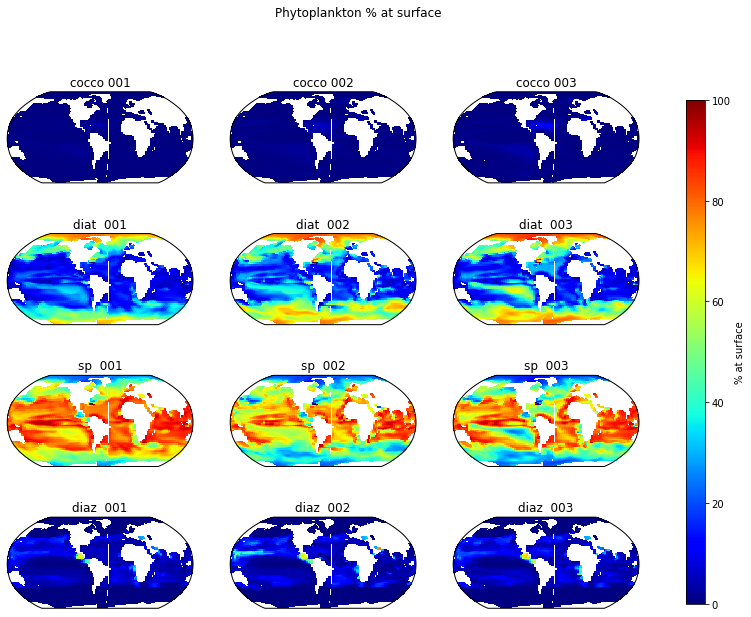

In [19]:
column=0

fig = plt.figure(figsize=(13,10))
plt.suptitle('Phytoplankton % at surface')
for casenum in casenums:
    
    column=column+1
    plot_num=column+0
    ax = fig.add_subplot(4,3,plot_num, projection=ccrs.Robinson(central_longitude=305.0))
    ax.set_title('cocco '+casenum, fontsize=12)
    pc=ax.pcolormesh(lons, lats, percent_phytoC_dict[casenum].cocco.isel(z_t_150m=0), cmap='jet',vmin=0,vmax=100,transform=ccrs.PlateCarree())
    
    plot_num=plot_num+3
    ax = fig.add_subplot(4,3,plot_num, projection=ccrs.Robinson(central_longitude=305.0))
    ax.set_title('diat  '+casenum, fontsize=12)
    pc=ax.pcolormesh(lons, lats, percent_phytoC_dict[casenum].diat.isel(z_t_150m=0), cmap='jet',vmin=0,vmax=100,transform=ccrs.PlateCarree())
    
    plot_num=plot_num+3
    ax = fig.add_subplot(4,3,plot_num, projection=ccrs.Robinson(central_longitude=305.0))
    ax.set_title('sp  '+casenum, fontsize=12)
    pc=ax.pcolormesh(lons, lats, percent_phytoC_dict[casenum].sp.isel(z_t_150m=0), cmap='jet',vmin=0,vmax=100,transform=ccrs.PlateCarree())

    plot_num=plot_num+3
    ax = fig.add_subplot(4,3,plot_num, projection=ccrs.Robinson(central_longitude=305.0))
    ax.set_title('diaz  '+casenum, fontsize=12)
    pc=ax.pcolormesh(lons, lats, percent_phytoC_dict[casenum].diaz.isel(z_t_150m=0), cmap='jet',vmin=0,vmax=100,transform=ccrs.PlateCarree())

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(pc, cax=cbar_ax, label='% at surface')

### Production maps

#### phytoplankton

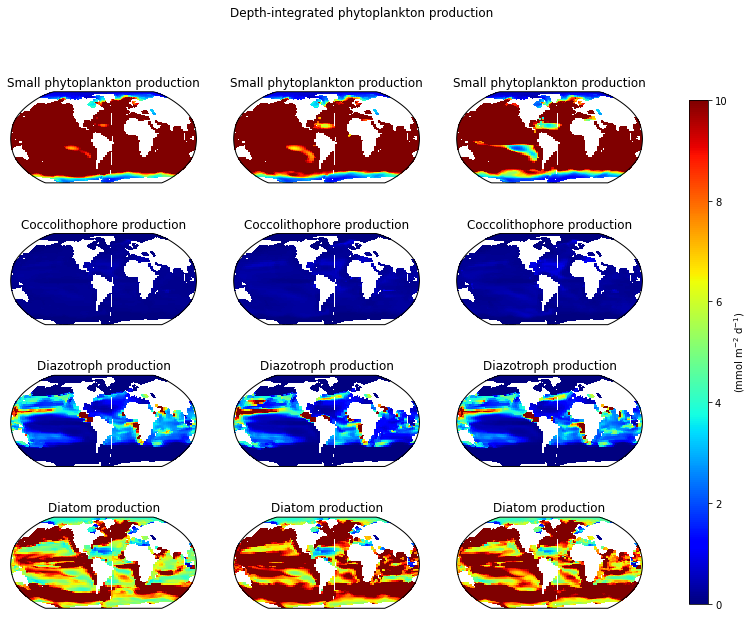

In [20]:
column=0
fig = plt.figure(figsize=(13,10))
plt.suptitle('Depth-integrated phytoplankton production')

for casenum in casenums:
    ############### phtyoplankton
    column=column+1
    plot_num=column+0
    
    ax = fig.add_subplot(4,3,plot_num, projection=ccrs.Robinson(central_longitude=305.0))
    ax.set_title('Small phytoplankton production', fontsize=12)
    tmp = ds_dict[casenum].photoC_sp_zint * 864.
    pc=ax.pcolormesh(lons, lats, tmp, cmap='jet',vmin=0,vmax=10,transform=ccrs.PlateCarree())
    
    plot_num=plot_num+3
    ax = fig.add_subplot(4,3,plot_num, projection=ccrs.Robinson(central_longitude=305.0))
    ax.set_title('Coccolithophore production', fontsize=12)
    tmp = ds_dict[casenum].photoC_cocco_zint * 864.
    pc=ax.pcolormesh(lons, lats, tmp, cmap='jet',vmin=0,vmax=10,transform=ccrs.PlateCarree())
    
    plot_num=plot_num+3
    ax = fig.add_subplot(4,3,plot_num, projection=ccrs.Robinson(central_longitude=305.0))
    ax.set_title('Diazotroph production', fontsize=12)
    tmp = ds_dict[casenum].photoC_diaz_zint * 864.
    pc=ax.pcolormesh(lons, lats, tmp, cmap='jet',vmin=0,vmax=10,transform=ccrs.PlateCarree())

    plot_num=plot_num+3
    ax = fig.add_subplot(4,3,plot_num, projection=ccrs.Robinson(central_longitude=305.0))
    ax.set_title('Diatom production', fontsize=12)
    tmp = ds_dict[casenum].photoC_diat_zint * 864.
    pc=ax.pcolormesh(lons, lats, tmp, cmap='jet',vmin=0,vmax=10,transform=ccrs.PlateCarree())


fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(pc, cax=cbar_ax, label='(mmol m$^{-2}$ d$^{-1}$)');

#### zooplankton

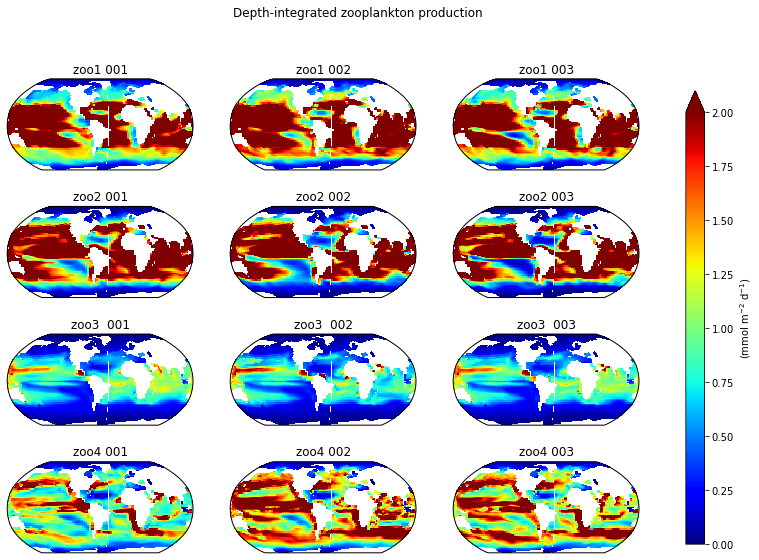

In [21]:
column=0
fig = plt.figure(figsize=(13,9))
plt.suptitle('Depth-integrated zooplankton production')

for casenum in casenums:
    
    column=column+1
    plot_num=column+0
    ############### zooplankton
    ax = fig.add_subplot(4,3,plot_num, projection=ccrs.Robinson(central_longitude=305.0))
    ax.set_title('zoo1 '+casenum, fontsize=12)
    tmp = ds_dict[casenum].x_graze_zoo1_zint * 864.
    pc=ax.pcolormesh(lons, lats, tmp, cmap='jet',vmin=0,vmax=2,transform=ccrs.PlateCarree())

    plot_num=plot_num+3
    ax = fig.add_subplot(4,3,plot_num, projection=ccrs.Robinson(central_longitude=305.0))
    ax.set_title('zoo2 '+casenum, fontsize=12)
    tmp = ds_dict[casenum].x_graze_zoo2_zint * 864.
    pc=ax.pcolormesh(lons, lats, tmp, cmap='jet',vmin=0,vmax=2,transform=ccrs.PlateCarree())

    plot_num=plot_num+3
    ax = fig.add_subplot(4,3,plot_num, projection=ccrs.Robinson(central_longitude=305.0))
    ax.set_title('zoo3  '+casenum, fontsize=12)
    tmp = ds_dict[casenum].x_graze_zoo3_zint * 864.
    pc=ax.pcolormesh(lons, lats, tmp, cmap='jet',vmin=0,vmax=2,transform=ccrs.PlateCarree())

    plot_num=plot_num+3
    ax = fig.add_subplot(4,3,plot_num, projection=ccrs.Robinson(central_longitude=305.0))
    ax.set_title('zoo4 '+casenum, fontsize=12)
    tmp = ds_dict[casenum].x_graze_zoo4_zint * 864.
    pc=ax.pcolormesh(lons, lats, tmp, cmap='jet',vmin=0,vmax=2,transform=ccrs.PlateCarree())
    
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(pc, cax=cbar_ax, label='(mmol m$^{-2}$ d$^{-1}$)',extend='max');

### Plot zooC

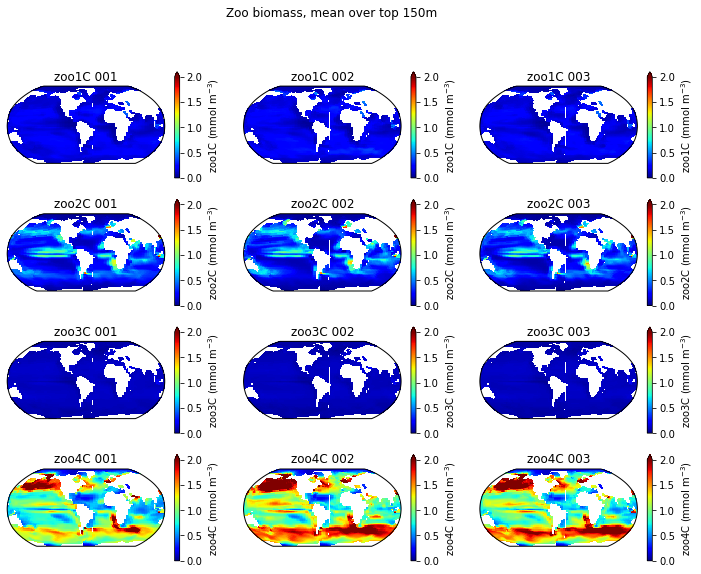

In [22]:
fig = plt.figure(figsize=(12,9))
column=0
plt.suptitle('Zoo biomass, mean over top 150m')
for casenum in casenums:
    
    column=column+1
    #print(plot_num)
    plot_num=column+0
    ax = fig.add_subplot(4,3,plot_num, projection=ccrs.Robinson(central_longitude=305.0))
    ax.set_title('zoo1C '+ casenum, fontsize=12)
    pc=ax.pcolormesh(lons, lats, ds_dict[casenum]['zoo1C'].mean(dim='z_t_150m'), cmap='jet',vmin=0,vmax=2,transform=ccrs.PlateCarree())
    cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='zoo1C (mmol m$^{-3}$)')
    
    plot_num=plot_num+3
    ax = fig.add_subplot(4,3,plot_num, projection=ccrs.Robinson(central_longitude=305.0))
    ax.set_title('zoo2C '+ casenum, fontsize=12)
    pc=ax.pcolormesh(lons, lats, ds_dict[casenum]['zoo2C'].mean(dim='z_t_150m'), cmap='jet',vmin=0,vmax=2,transform=ccrs.PlateCarree())
    cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='zoo2C (mmol m$^{-3}$)')
    
    plot_num=plot_num+3
    ax = fig.add_subplot(4,3,plot_num, projection=ccrs.Robinson(central_longitude=305.0))
    ax.set_title('zoo3C '+ casenum, fontsize=12)
    pc=ax.pcolormesh(lons, lats, ds_dict[casenum]['zoo3C'].mean(dim='z_t_150m'), cmap='jet',vmin=0,vmax=2,transform=ccrs.PlateCarree())
    cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='zoo3C (mmol m$^{-3}$)')
    
    plot_num=plot_num+3
    ax = fig.add_subplot(4,3,plot_num, projection=ccrs.Robinson(central_longitude=305.0))
    ax.set_title('zoo4C '+ casenum, fontsize=12)
    pc=ax.pcolormesh(lons, lats, ds_dict[casenum]['zoo4C'].mean(dim='z_t_150m'), cmap='jet',vmin=0,vmax=2,transform=ccrs.PlateCarree())
    cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='zoo4C (mmol m$^{-3}$)')

### Globally integrated production

In [23]:
nmols_to_PgCyr = 1e-9 * 12. * 1e-15 * 365. * 86400.

In [24]:
variables = [f'photoC_{phyto}_zint' for phyto in ['diat', 'sp', 'diaz', 'cocco', 'TOT']]

variables = variables + [f'x_graze_{zoo}_zint' for zoo in ['zoo1', 'zoo2', 'zoo3','zoo4']]

variables = variables + ['CaCO3_PROD_zint']

dict_glb = {}
for casenum in casenums:
    
    ds_glb = xr.Dataset()
    for v in variables:
        ds_glb[v] = esmlab.statistics.weighted_sum(ds_dict[casenum][v], weights=area, dim=['nlat', 'nlon'])
        ds_glb[v].attrs = ds_dict[casenum][v].attrs

        #if ds1_annmean[v].units == 'mmol/m^3 cm/s':
        ds_glb[v] = ds_glb[v] * nmols_to_PgCyr        
        ds_glb[v].attrs['units'] = 'Pg C yr$^{-1}$'

    ds_glb = ds_glb.compute()
    
    ds_glb['TOTzoo']= ds_glb['x_graze_zoo1_zint'] + ds_glb['x_graze_zoo2_zint'] + ds_glb['x_graze_zoo3_zint'] + ds_glb['x_graze_zoo4_zint']
    
    dict_glb[casenum]=ds_glb

In [26]:
dict_glb[casenums[0]]

<xarray.Dataset>
Dimensions:            ()
Data variables:
    photoC_diat_zint   float64 14.64
    photoC_sp_zint     float64 46.61
    photoC_diaz_zint   float64 2.942
    photoC_cocco_zint  float64 0.2532
    photoC_TOT_zint    float64 64.45
    x_graze_zoo1_zint  float64 2.932
    x_graze_zoo2_zint  float64 3.582
    x_graze_zoo3_zint  float64 0.9213
    x_graze_zoo4_zint  float64 1.748
    CaCO3_PROD_zint    float64 0.07084
    TOTzoo             float64 9.183

In [27]:
goals_dict={}

for casenum in casenums:
    goals=xr.Dataset()
    goals['NPP'] = 55
    goals['diatNPP'] = 0.4 * dict_glb[casenum].photoC_TOT_zint.values
    goals['zooPROD'] = 0.25 * dict_glb[casenum].photoC_TOT_zint.values
    #goals['microzooPROD'] = 0.6 * dict_glb[casenum].x_graze_zoo1_zint.values + dict_glb[casenum].x_graze_zoo2_zint.values #(so uncertain!!)
    
    goals_dict[casenum]=goals
    

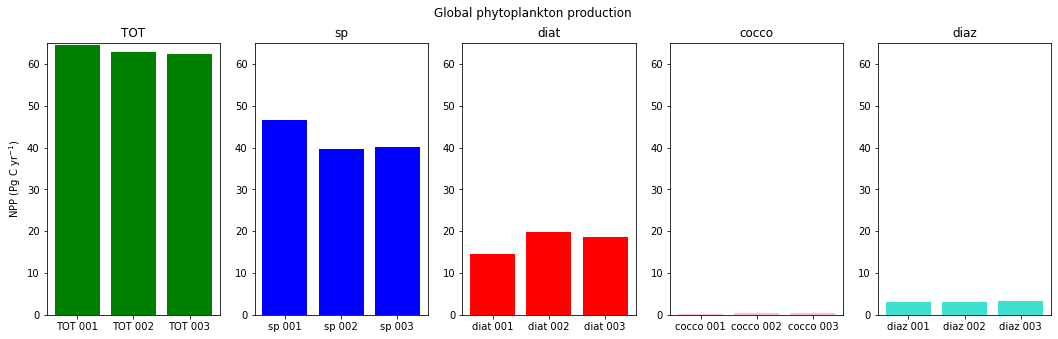

In [29]:
fig = plt.figure(figsize=(18,5))

plt.suptitle('Global phytoplankton production')

####### TOT
i=0
labels=[]
vals=np.zeros([3])
for casenum in casenums:
    
    labels=labels+['TOT '+casenum]
    vals[i]=dict_glb[casenum].photoC_TOT_zint.values
    i=i+1
    
ax = fig.add_subplot(1,5,1)
ax.bar(labels, vals,color='green')
# ax.plot([0,1,2],[goals_dict[casenum].NPP.values,goals_dict[casenum].NPP.values,goals_dict[casenum].NPP.values], color='black', marker='*')

ax.set_ylim(0,65)
ax.set_ylabel('NPP (Pg C yr$^{-1}$)')
ax.set_title('TOT')

####### sp
i=0
labels=[]
vals=np.zeros([3])
for casenum in casenums:
    
    labels=labels+['sp '+casenum]
    vals[i]=dict_glb[casenum].photoC_sp_zint.values
    i=i+1
    
ax = fig.add_subplot(1,5,2)
ax.bar(labels, vals,color='blue')
ax.set_ylim(0,65)
ax.set_title('sp')

####### diat
i=0
labels=[]
vals=np.zeros([3])
for casenum in casenums:
    
    labels=labels+['diat '+casenum]
    vals[i]=dict_glb[casenum].photoC_diat_zint.values
    i=i+1
    
ax = fig.add_subplot(1,5,3)
#ax.axhline(goals_dict[casenum].diatNPP.values, color='black', linestyle='--', lw=2)

ax.bar(labels, vals,color='red')
ax.set_ylim(0,65)
ax.set_title('diat')

####### cocco
i=0
labels=[]
vals=np.zeros([3])
for casenum in casenums:
    
    labels=labels+['cocco '+casenum]
    vals[i]=dict_glb[casenum].photoC_cocco_zint.values
    i=i+1
    
ax = fig.add_subplot(1,5,4)
ax.bar(labels, vals,color='pink')
ax.set_ylim(0,65)
ax.set_title('cocco')

####### diaz
i=0
labels=[]
vals=np.zeros([3])
for casenum in casenums:
    
    labels=labels+['diaz '+casenum]
    vals[i]=dict_glb[casenum].photoC_diaz_zint.values
    i=i+1
    
ax = fig.add_subplot(1,5,5)
ax.bar(labels, vals,color='turquoise')
ax.set_ylim(0,65)
ax.set_title('diaz');

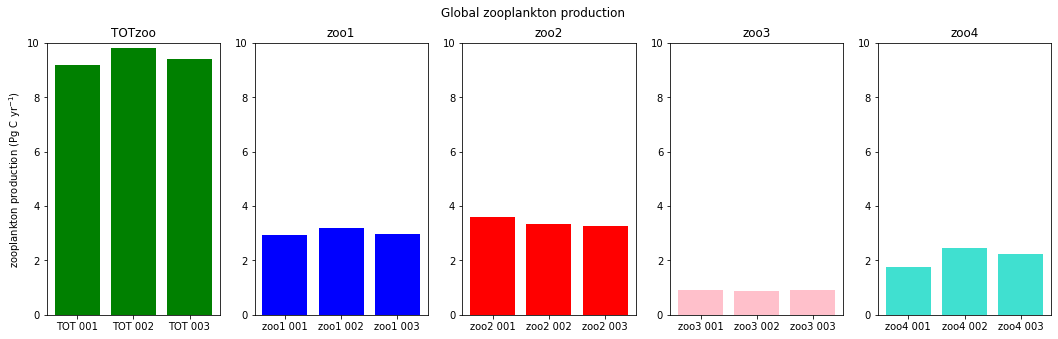

In [31]:
fig = plt.figure(figsize=(18,5))

plt.suptitle('Global zooplankton production')

####### TOT
i=0
labels=[]
vals=np.zeros([3])
for casenum in casenums:
    
    labels=labels+['TOT '+casenum]
    vals[i]=dict_glb[casenum].TOTzoo.values
    i=i+1
    
ax = fig.add_subplot(1,5,1)
ax.bar(labels, vals,color='green')
ax.set_ylim(0,10)
ax.set_ylabel('zooplankton production (Pg C yr$^{-1}$)')
ax.set_title('TOTzoo')

####### sp
i=0
labels=[]
vals=np.zeros([3])
for casenum in casenums:
    
    labels=labels+['zoo1 '+casenum]
    vals[i]=dict_glb[casenum].x_graze_zoo1_zint.values
    i=i+1
    
ax = fig.add_subplot(1,5,2)
ax.bar(labels, vals,color='blue')
ax.set_ylim(0,10)
ax.set_title('zoo1')

####### diat
i=0
labels=[]
vals=np.zeros([3])
for casenum in casenums:
    
    labels=labels+['zoo2 '+casenum]
    vals[i]=dict_glb[casenum].x_graze_zoo2_zint.values
    i=i+1
    
ax = fig.add_subplot(1,5,3)
ax.bar(labels, vals,color='red')
ax.set_ylim(0,10)
ax.set_title('zoo2')

####### cocco
i=0
labels=[]
vals=np.zeros([3])
for casenum in casenums:
    
    labels=labels+['zoo3 '+casenum]
    vals[i]=dict_glb[casenum].x_graze_zoo3_zint.values
    i=i+1
    
ax = fig.add_subplot(1,5,4)
ax.bar(labels, vals,color='pink')
ax.set_ylim(0,10)
ax.set_title('zoo3')

####### diaz
i=0
labels=[]
vals=np.zeros([3])
for casenum in casenums:
    
    labels=labels+['zoo4 '+casenum]
    vals[i]=dict_glb[casenum].x_graze_zoo4_zint.values
    i=i+1
    
ax = fig.add_subplot(1,5,5)
ax.bar(labels, vals,color='turquoise')
ax.set_ylim(0,10)
ax.set_title('zoo4');

#### Zooplankton production should be ~25% of NPP
#### Microzooplankton (zoo1 + zoo2) should be ~60% of total zooplankton production

#### Zooplankton production = (zoo grazing - zoo respiration)

### COPEPOD comparison

In [32]:
#the m00 is the annual data, and m01-m12 are monthlies, and then m13-16 are quarterlies.
#file='/glade/work/jluo/obs/COPEPOD/data/copepod-2012__cmass-m00-qtr_POP_gx3v7.nc'
file='/glade/work/kristenk/copepod_data/COPEPOD_m00_x3POPgrid.nc'
ds_copepod=xr.open_dataset(file, decode_times=False)
ds_copepod['carbon_biomass']=ds_copepod.carbon_biomass / 12. #convert to mmol/m3 from mg/m3
ds_copepod = ds_copepod.squeeze()

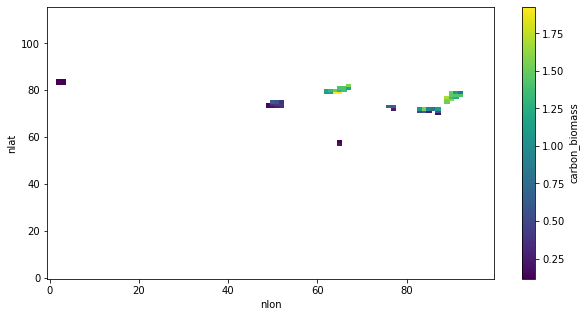

In [33]:
ds_copepod.carbon_biomass.plot(figsize=(10,5))

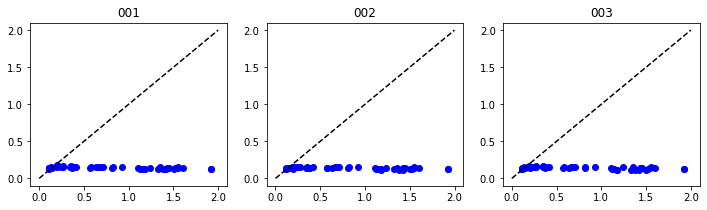

In [35]:
#### make line plots plotting mesozooplankton abundance versus COPEPOD database

### PREP
one2one = np.array([0, 2])
x_vals = ds_copepod.carbon_biomass.values
x_vals = x_vals.flatten()

fig = plt.figure(figsize=(12,3))
plotnum=0
for casenum in casenums:
        plotnum=plotnum+1
        
        #set up the vals
        y_vals = ds_dict[casenum].zoo3C.isel(z_t_150m=0).where(ds_copepod.carbon_biomass>0.).values
        y_vals = y_vals.flatten()
        
        
        ax = fig.add_subplot(1,3,plotnum)
        ax.set_title(casenum)
        ax.scatter(x_vals,y_vals,color='blue',marker='o',
                   label='control')

        ax.plot(one2one,one2one,color='black',linestyle='--')

#ax.plot(yr_2iaf,line_alk_control,'--',color='blue')

### Chlorophyll (compare to MODIS mean over 2003 to 2018)

In [38]:
file='/glade/work/kristenk/satellite_data/POP_regrid/MODIS_meanCHL2003to2018_mgm3_x3POPgrid.nc'
ds_chl=xr.open_dataset(file, decode_times=False)

In [39]:
for casenum in casenums:
    ds_dict[casenum]['TOT_Chl']=ds_dict[casenum].spChl + ds_dict[casenum].diatChl + ds_dict[casenum].diazChl + ds_dict[casenum].coccoChl

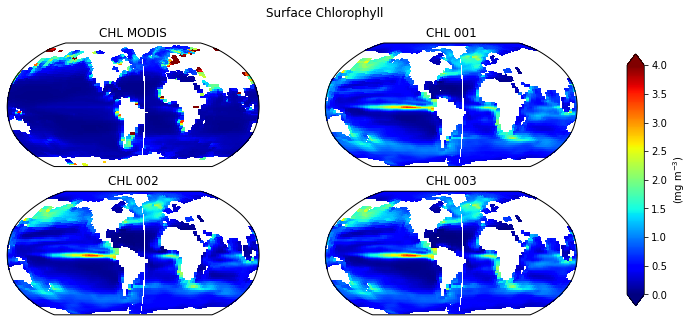

In [40]:
fig = plt.figure(figsize=(12,5))
column=0
plot_num=1
plt.suptitle('Surface Chlorophyll')

ax = fig.add_subplot(2,2,plot_num, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('CHL MODIS', fontsize=12)
pc=ax.pcolormesh(lons, lats, ds_chl.CHL, cmap='jet',vmin=0,vmax=4,transform=ccrs.PlateCarree())
plot_num = plot_num + 1

for casenum in casenums:
    
    ax = fig.add_subplot(2,2,plot_num, projection=ccrs.Robinson(central_longitude=305.0))
    ax.set_title('CHL '+ casenum, fontsize=12)
    pc=ax.pcolormesh(lons, lats, ds_dict[casenum]['TOT_Chl'].isel(z_t_150m=0), cmap='jet',vmin=0,vmax=4,transform=ccrs.PlateCarree())
    plot_num = plot_num + 1
    
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(pc, cax=cbar_ax, label='(mg m$^{-3}$)', extend='both');

### Calcification

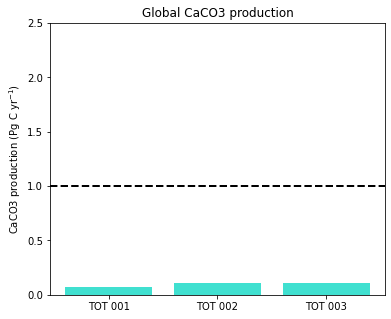

In [43]:
fig = plt.figure(figsize=(6,5))
####### TOT
i=0
labels=[]
vals=np.zeros([3])
for casenum in casenums:
    
    labels=labels+['TOT '+casenum]
    vals[i]=dict_glb[casenum].CaCO3_PROD_zint.values
    i=i+1
    
ax = fig.add_subplot(1,1,1)
ax.bar(labels, vals,color='turquoise')
ax.set_ylim(0,2.5)
ax.set_ylabel('CaCO3 production (Pg C yr$^{-1}$)')
ax.set_title('Global CaCO3 production')
ax.axhline(1, color='black', linestyle='--', lw=2)


In [44]:
#read in mean PIC
pic_file = '/glade/work/kristenk/satellite_data/processed/PIC_mean2003to2018_1deg.nc'
ds_pic=xr.open_dataset(pic_file, decode_times=False)
#ds_pic.PIC

In [45]:
#convert to mmol/m3 from mg/m3
ds_pic['PIC']=ds_pic.PIC / 12.011

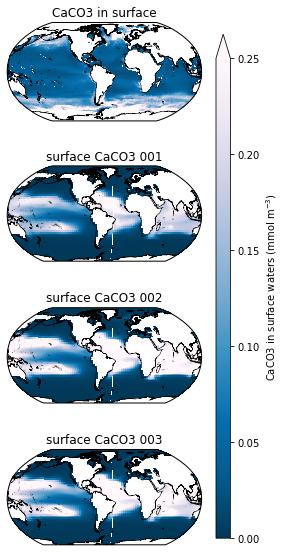

In [47]:
fig = plt.figure(figsize=(4,10))


ax = fig.add_subplot(4,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('CaCO3 in surface', fontsize=12)
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(ds_pic.lon.values, ds_pic.lat.values, ds_pic.PIC, cmap='PuBu_r',vmin=0,vmax=0.25,transform=ccrs.PlateCarree())

plotnum=2
for casenum in casenums:
    ax = fig.add_subplot(4,1,plotnum, projection=ccrs.Robinson(central_longitude=305.0))
    ax.set_title('surface CaCO3 '+casenum, fontsize=12)
    ax.coastlines('10m',linewidth=0.5)
    pc=ax.pcolormesh(lons, lats, ds_dict[casenum].coccoCaCO3.isel(z_t_150m=0), cmap='PuBu_r',vmin=0,vmax=0.25,transform=ccrs.PlateCarree())
    plotnum=plotnum+1
    
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(pc, cax=cbar_ax, label='CaCO3 in surface waters (mmol m$^{-3}$)',extend='max');

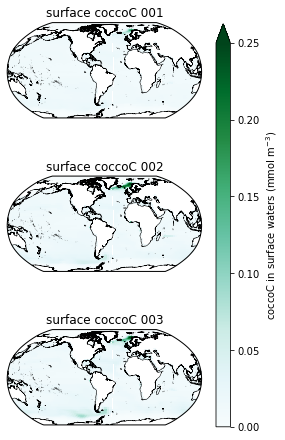

In [48]:
fig = plt.figure(figsize=(4,8))

plotnum=1
for casenum in casenums:
    ax = fig.add_subplot(3,1,plotnum, projection=ccrs.Robinson(central_longitude=305.0))
    ax.set_title('surface coccoC '+casenum, fontsize=12)
    ax.coastlines('10m',linewidth=0.5)
    pc=ax.pcolormesh(lons, lats, ds_dict[casenum].coccoC.isel(z_t_150m=0), cmap='BuGn',vmin=0,vmax=0.25,transform=ccrs.PlateCarree())
    plotnum=plotnum+1
    
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(pc, cax=cbar_ax, label='coccoC in surface waters (mmol m$^{-3}$)',extend='max');